# Đồ họa thống kê với Python

# Biểu đồ Bland-Altman

### BS. Lê Ngọc Khả Nhi

# Giới thiệu

Trong nghiên cứu y học, có một bài toán khá phổ biến là khảo sát về mức độ tương hợp (hay sai biệt) giữa 2 thiết bị/cách thức đo lường áp dụng cho cùng một đại lượng sinh học. Phương pháp thường dùng là Bland-Altman. 

Phương pháp phân tích này do 2 nhà thống kê Bland và Altman đề xuất vào năm 1983, nội dung của nó gồm có 3 phần:

Phần giả định: mục tiêu thứ nhất của quy trình là kiểm chứng 2 giả định: 1) Sai biệt trung bình giữa 2 kết quả là hằng định trên toàn bộ giới hạn của thang đo, và 2) Sự dao động (ngẫu nhiên) của sai biệt cũng ổn định trên toàn bộ thang đo.

Phần phân tích định lượng: mục tiêu là ước tính 3 trị số: Trung bình của sai biệt, và 2 giới hạn trên/dưới của sai biệt, được xác định đơn giản = mean +/- 1.96 * SD (tương ứng 95% mật độ phân bố) với giả định sai biệt có phân bố chuẩn. 

Phần đồ họa: Một biểu đồ được dựng lên cho phép kiểm tra trực quan 2 giả định, mức độ sai biệt so với kết quả tối ưu (sai biệt = 0), và nhận diện các trường hợp vượt ra khỏi giới hạn trên/dưới của sai biệt cho phép. Biểu đồ này có tên riêng là Bland-Altman plot, nhưng bản chất của nó đơn giản là 1 biểu đồ tán xạ có trục hoành X biểu thị trung bình của 2 phép đo (xem như 1 phép ước lượng thang đo chuẩn), và trục tung Y biểu thị sai biệt. Người ta thường vẽ thêm các đường thẳng để định vị sai biệt = 0, sai biệt trung bình, 2 ngưỡng trên/dưới của khoảng sai biệt cho phép.

Altman DG, Bland JM (1983). "Measurement in medicine: the analysis of method comparison studies". The Statistician. 32 (3): 307–317.

# Reinventing the wheel

Có nhiều biến thể của biểu đồ Bland-Altman trong y văn, và trong bài hôm nay Nhi cũng sẽ tạo ra một biến thể như vậy, dựa vào một số quan điểm chủ quan như sau:

Thay vì biểu thị trung bình của 2 phép đo, Nhi dùng trục hoành để chỉ chính xác 1 phép đo chuẩn (tham chiếu, tiêu chuẩn vàng).

Nhi sử dụng 1 biểu đồ kết hợp (jointplot) gồm 3 bộ phận: 1 biểu đồ tán xạ (có thể kèm mật độ phân phối 2 chiều - 2D KDE plot) làm trung tâm, kết hợp với 2 biểu đồ mật độ phân phối 1 chiều để biểu thị marginal distribution. Công dụng của những KDE plot nhằm biểu thị phân phối thực sự của dữ liệu, với quan điểm là đại lượng cần đo và sai biệt có thể không theo phân phối Gaussian. 

Những biểu đồ trên có thể được tô màu theo phân nhóm (thí dụ độ nặng của 1 căn bệnh, hay các phân nhóm khác nhau).

Nhi dùng trung vị và bách phân vị thứ 5+95 thay vì trung bình +/- 1.96 SD, với cùng lý do là phân bố của sai biệt có thể không chuẩn.

Chúng ta cùng dựng biểu đồ này với matplotlib và seaborn nhé.

Trước hết ta tạo 1 dữ liệu mô phỏng với 3 phân nhóm A,B,C, 2 kết quả đo bởi phương pháp Tiêu chuẩn (Ref) và Phương pháp mục tiêu cần khảo sát (Target), cùng khác biệt giữa chúng (Difference)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
import scipy.stats as st

import warnings
warnings.filterwarnings('ignore')

In [3]:
ba_df = pd.DataFrame({'Class':[],
                      'Ref':[],})

for m,c in zip([1,3,6],list('ABC')):
    temp = pd.DataFrame({'Class':list(c*100),
                        'Ref': np.random.gamma(m,0.5,100),
                        'Target': np.random.gamma(m,0.5,100) - np.random.gamma(m/2,1,100)})
    ba_df = pd.concat([ba_df, temp])

ba_df['Difference'] = ba_df['Target'] - ba_df['Ref']
    
ba_df

,Class,Ref,Target,Difference
0,A,0.495232,-0.579250,-1.074483
1,A,0.015193,0.077629,0.062435
2,A,0.936245,0.123573,-0.812672
3,A,0.091631,0.041656,-0.049975
4,A,0.188730,0.130308,-0.058422
...,...,...,...,...
95,C,3.312299,-1.227511,-4.539809
96,C,0.949034,0.691042,-0.257992
97,C,1.728806,-2.857484,-4.586290
98,C,2.971207,0.393066,-2.578142


In [6]:
ba_df.groupby('Class').describe(percentiles = [0.05,0.5,0.95])['Difference']

,count,mean,std,min,5%,50%,95%,max
Class,,,,,,,,
A,100.0,-0.461957,1.178293,-4.725122,-2.252428,-0.333853,0.972728,4.208526
B,100.0,-1.447079,1.650813,-8.748119,-3.910196,-1.125448,0.668753,1.775190
C,100.0,-2.890224,2.381999,-10.463445,-6.620455,-2.613758,0.509139,2.322650


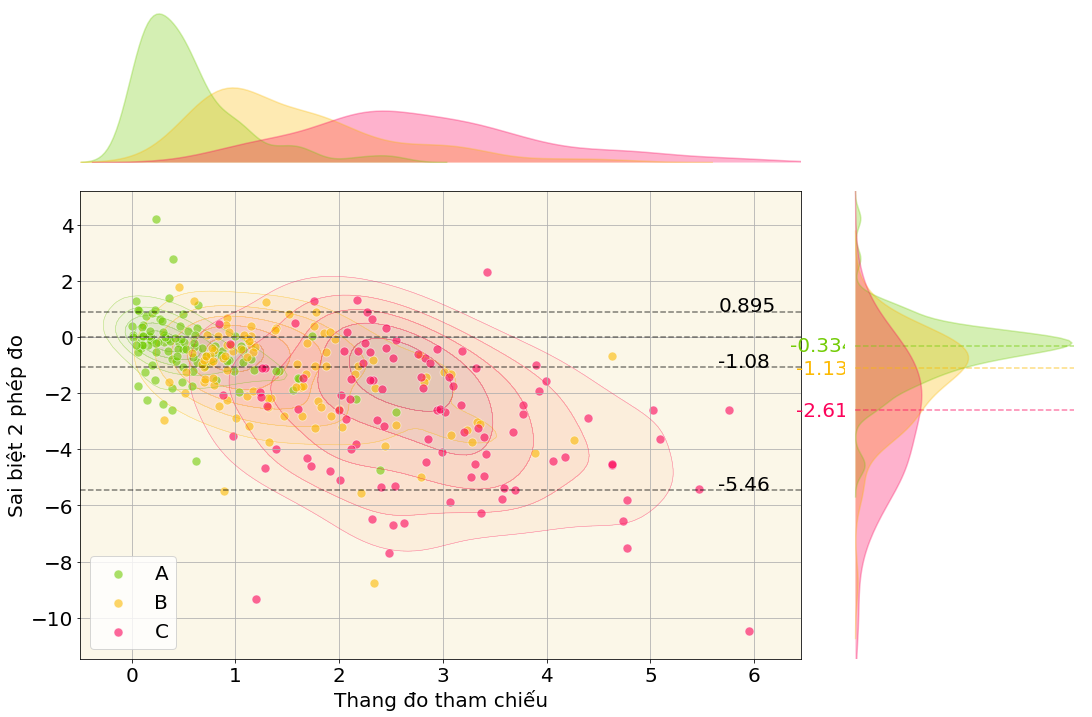

In [14]:
# Kích thước font chữ
plt.rcParams.update({'font.size': 20})

# Thiết kế lưới biểu đồ 2x2, tỉ lệ rộng 3:1 và cao 1:3 dùng GridSpec:

gs = gridspec.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[1,3])
gs.update(hspace=0.09, wspace=0.09)

# Tạo object biểu đồ kích thước 16x10, nền trắng

fig = plt.figure(figsize=(18,12))

fig.patch.set_facecolor('white')

# Tạo 2 phổ màu liên tục/rời rạc cho 3 phân nhóm
fill = ['Greens','YlOrRd','Reds'] 
edge = ['#73cc06', '#fcba03', '#fc035a']

# Tính 3 trị số Median, phân vị 5 và 95 của Difference cho toàn quần thể
ba_stat = ba_df['Difference'].describe(percentiles = [0.05,0.5,0.95])[4:7].to_list()

# Xác định giới hạn trên và dưới của trục hoành, trục tung

xmin, xmax = min(ba_df['Ref'])-0.5, max(ba_df['Ref'])+0.5
ymin, ymax = min(ba_df['Difference'])-1, max(ba_df['Difference'])+1

# Thiết kế hệ trục cho panel chính (2D KDE và tán xạ)
ax = plt.subplot(gs[1,0]) 
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(True)

ax.set_ylabel('Sai biệt 2 phép đo')
ax.set_xlabel('Thang đo tham chiếu')

# Vẽ KDE plots

for s,fc,ec in zip(ba_df['Class'].unique(), fill, edge):
    x = ba_df[ba_df['Class'] == s]['Ref'].values
    y = ba_df[ba_df['Class'] == s]['Difference'].values
    n = len(x)

    # Ước tính kernel density 2D cho mỗi phân nhóm
    
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    
    # Vẽ 2D KDE plot (lớp nền của panel chính)
    
    cfset = ax.contourf(xx, yy, f, levels=5, cmap = fc, alpha = 0.2, extend = 'neither')
    cset = ax.contour(xx, yy, f, colors = ec, levels=5, linewidths=0.5, alpha = 0.5)
    
    # Vẽ 2 1D KDE plot cho marginal distribution
    
    axl = plt.subplot(gs[0,0], sharex=ax) # Instantiate right KDE plot area
    axl.get_xaxis().set_visible(False) 
    axl.get_yaxis().set_visible(False)
    axl.spines["right"].set_visible(False)
    axl.spines["left"].set_visible(False)
    axl.spines["top"].set_visible(False)
    axl.spines["bottom"].set_visible(False)
    
    axb = plt.subplot(gs[1,1], sharey=ax) # Instantiate top KDE plot area
    axb.get_xaxis().set_visible(False) # Hide tick marks and spines
    axb.get_yaxis().set_visible(False)
    axb.spines["right"].set_visible(False)
    axb.spines["left"].set_visible(False)
    axb.spines["top"].set_visible(False)
    axb.spines["bottom"].set_visible(False)
    
    # Trục tung
    axb = sns.kdeplot(y, 
                      ax = axb, 
                      color = ec, 
                      shade = True, 
                      alpha = 0.3,
                      vertical = True)
    # trục hoành
    axl = sns.kdeplot(x, 
                      ax = axl, 
                      color = ec, 
                      alpha = 0.3,
                      shade = True, 
                      vertical = False)

# Vẽ biểu đồ tán xạ, hiển thị trị số thống kê

for s,ec in zip(ba_df['Class'].unique(), edge):
    x = ba_df[ba_df['Class'] == s]['Ref'].values
    y = ba_df[ba_df['Class'] == s]['Difference'].values
    
    xm = np.median(x)
    ym = np.median(y)
    
    # Trị số cho quần thể
    ax.text(xmax + 0.2, ym, f'{ym:.3}', 
            ha='center', 
            va='center',
            color= ec)
    
    axb.hlines(y = ym, xmin = 0, xmax=0.5,
         linestyles = 'dashed',
         alpha = 0.5,
         color = ec)
    
    # Biểu đồ tán xạ
    sns.scatterplot(x,y,
                ax = ax, 
                alpha = 0.6, 
                color = ec, 
                s = 80,
                label = s)

# Legend panel chính
ax.legend(loc = 'lower left')

ax.hlines(y = ba_stat + [0],
          xmin = xmin, 
          xmax = xmax,
         linestyles = 'dashed',
         alpha = 0.5)

# Trị số cho phân nhóm
for i in ba_stat:
    ax.text(x = xmax - 0.8, 
            y = i,
            s = f'{i:.3}',
            color='k')
    
plt.show()